In [1]:
#Import libraries
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

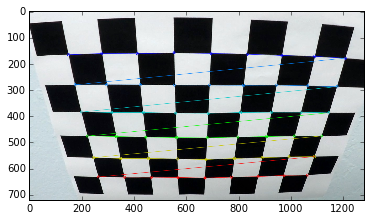

In [5]:
#Finding corners in a one image (for testing)
nx = 9
ny = 6

# Make a list of calibration images
fname = 'camera_cal/calibration2.jpg'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.savefig('output_images/corners')

In [6]:
# Make a list of calibration images
calibration_images = glob.glob('camera_cal/calibration*.jpg')

In [7]:
def get_img_obj_points():
    # prepare object points
    nx = 9
    ny = 6

    #Array to store object points and image points from all the images
    objPoints = [] #3D points
    imgPoints = [] #2D points

    #Prepare object points like (0,0,0), (1,0,0) to (8,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #x, y coordinates

    for image in calibration_images:
        img = mpimg.imread(image)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #     print (ret)

        # If found, draw corners
        if ret == True:
            imgPoints.append(corners)
            objPoints.append(objp)
    return imgPoints, objPoints

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [8]:
imgPoints, objPoints = get_img_obj_points()

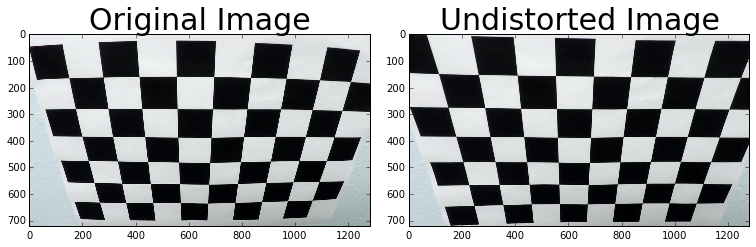

In [9]:
test_img='camera_cal/calibration2.jpg'

# Read in an image
img = cv2.imread(test_img)
undistorted = cal_undistort(img, objPoints, imgPoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/undistorted')

In [10]:
def get_undistorted_images(images):
    undistorted_images = []
    for image in images:
        img = cv2.imread(image)
        undistort = cal_undistort(img, objPoints, imgPoints)
        undistorted_images.append(undistort)
    return undistorted_images

undistorted_images = get_undistorted_images(calibration_images)    

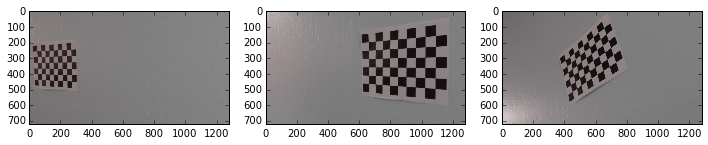

In [11]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
f.tight_layout()
ax1.imshow(undistorted_images[2])
ax2.imshow(undistorted_images[3])
ax3.imshow(undistorted_images[4])

In [12]:
#load test images
# test_images_files = glob.glob('test_images/*.jpg')
test_images = glob.glob('test_images/*.jpg')

In [13]:
test_undistorted = get_undistorted_images(test_images)

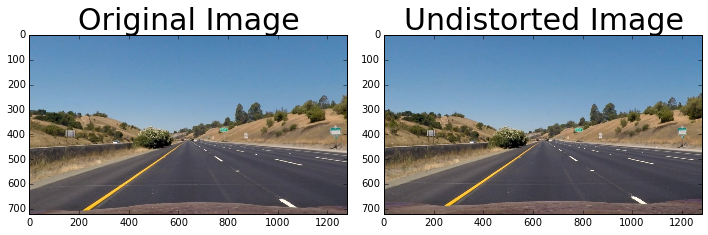

In [15]:
test_undistorted_rgb = []
for image in test_undistorted:
    test_undistorted_rgb.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(test_undistorted_rgb[0])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('output_images/undistorted_test')

## Absolute Threshold, Magnitude Threshold, Direction threshold

In [16]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1,0,ksize = sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0,1,ksize = sobel_kernel)
    mag = np.absolute(sobel)
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    grad_binary =  np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0,1,ksize = sobel_kernel)
    grad_mag = np.sqrt(sobelx**2+sobely**2)
    scaled_sobel = np.uint8(255*grad_mag/np.max(grad_mag))
    mag_binary =  np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0,1,ksize = sobel_kernel)
    magx = np.absolute(sobelx)
    magy = np.absolute(sobely)
    grad_dir = np.arctan2(magy, magx)
    dir_binary =  np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return dir_binary

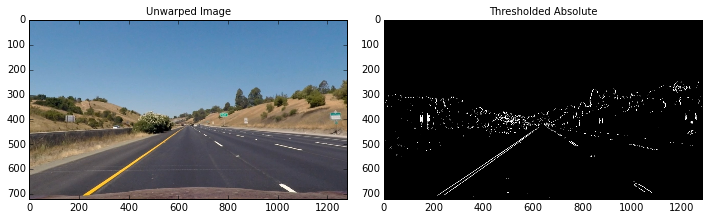

In [18]:
sample_img = test_undistorted_rgb[0]

ksize = 3
gray_scaled = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
sobelabs_unwarp_x = abs_sobel_thresh(gray_scaled, 'x', thresh=(40, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(sample_img)
ax1.set_title('Unwarped Image', fontsize=10)
ax2.imshow(sobelabs_unwarp_x, cmap='gray')
ax2.set_title('Thresholded Absolute', fontsize=10)
plt.savefig('output_images/sobelx')

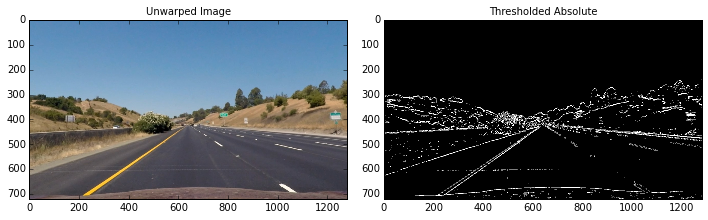

In [19]:
ksize = 3
gray_scaled = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
sobelabs_unwarp_y = abs_sobel_thresh(gray_scaled, orient='y', sobel_kernel=ksize, thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(sample_img)
ax1.set_title('Unwarped Image', fontsize=10)
ax2.imshow(sobelabs_unwarp_y, cmap='gray')
ax2.set_title('Thresholded Absolute', fontsize=10)
plt.savefig('output_images/sobely')

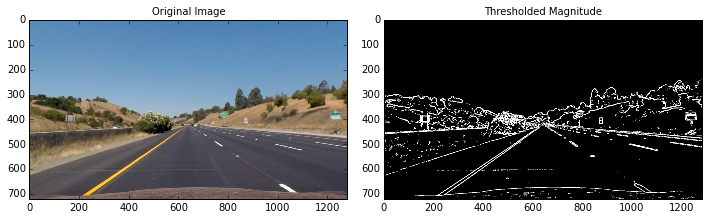

In [20]:
gray_scaled = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
mag_binary = mag_thresh(gray_scaled, sobel_kernel=ksize, thresh=(30, 225))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=10)
plt.savefig('output_images/mag_thresh')

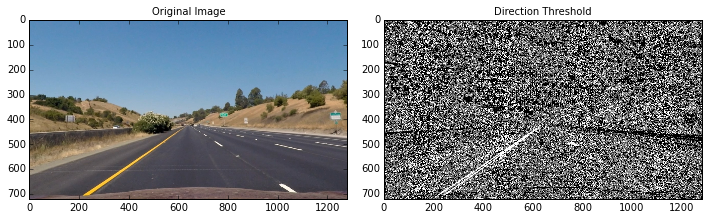

In [21]:
gray_scaled = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
dir_binary = dir_threshold(gray_scaled, sobel_kernel=ksize, thresh=(0.7, 1.3))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Direction Threshold', fontsize=10)
plt.savefig('output_images/direction_thresh')

### Combining the Absolute, Magnitude, Direction Thresholds on the Grayscale image

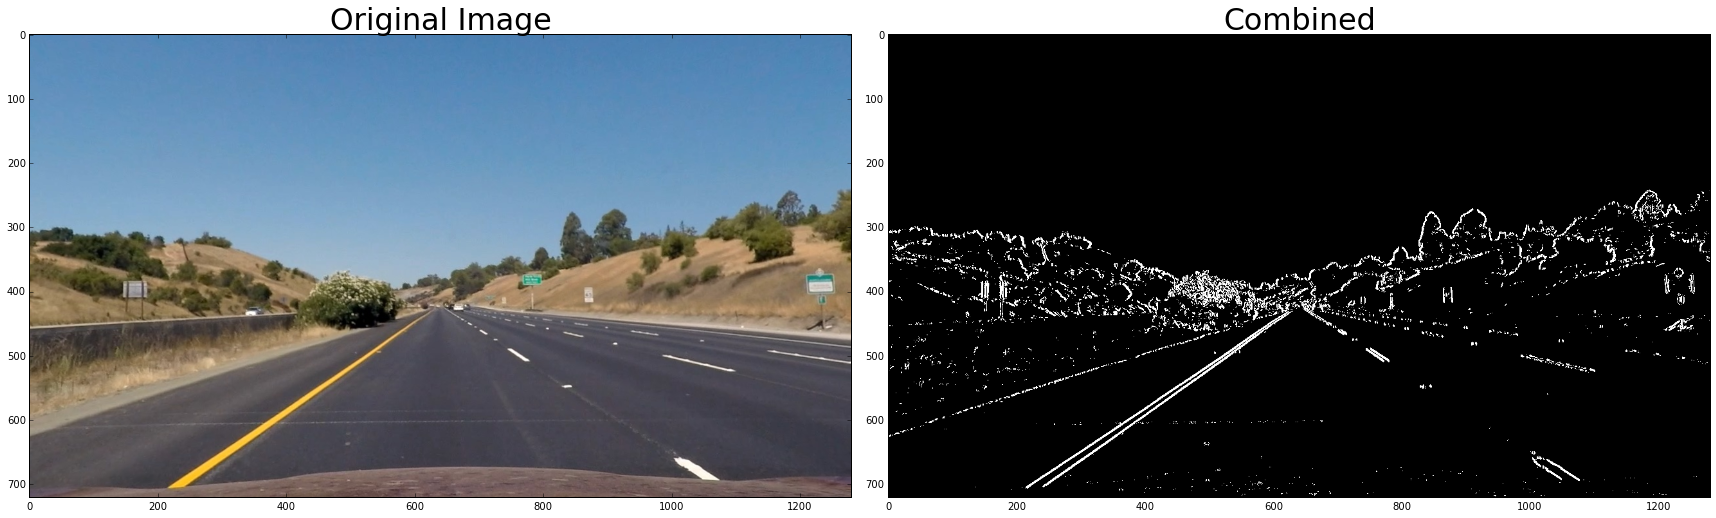

In [22]:
combined = np.zeros_like(dir_binary)
combined[(sobelabs_unwarp_x == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=30)
plt.savefig('output_images/combined_initial')

## Color Threshold

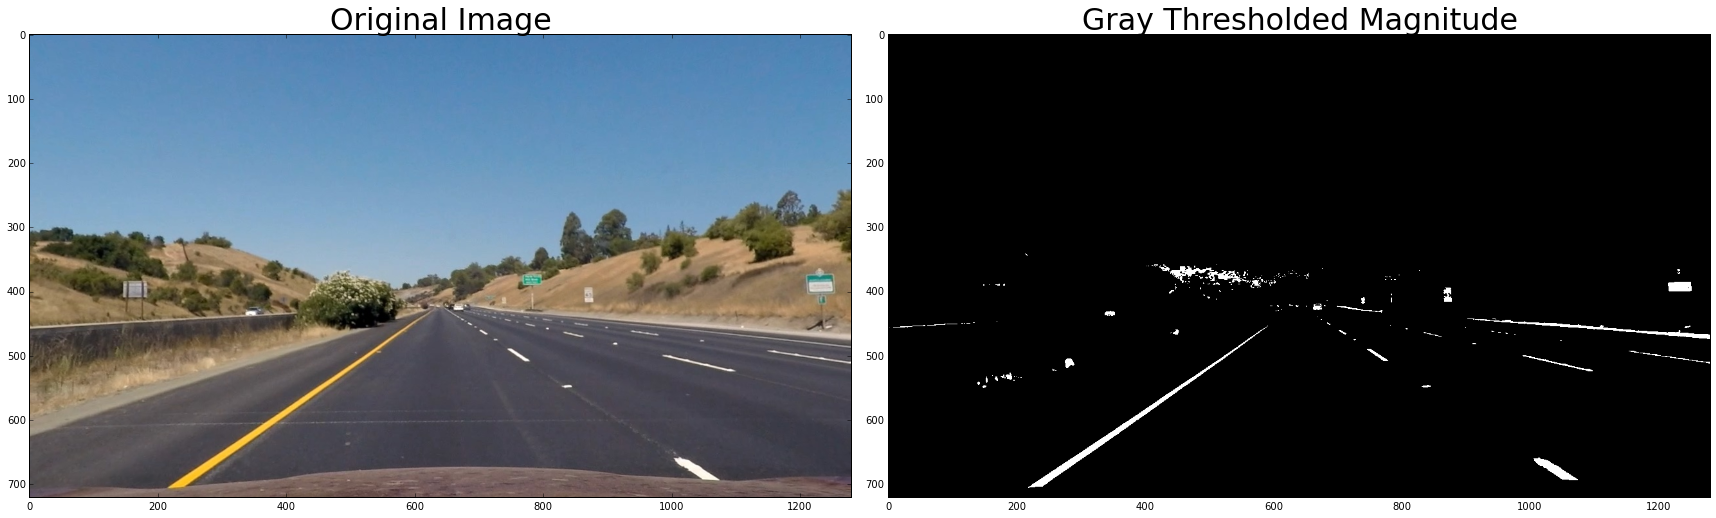

In [23]:
thresh = (180, 255)
gray = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Gray Thresholded Magnitude', fontsize=30)
plt.savefig('output_images/color_gray_thresh')

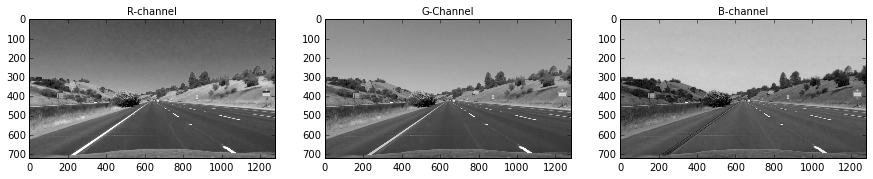

In [24]:
# Visualize RGB color space channels
channel_R = sample_img[:,:,0]
channel_G = sample_img[:,:,1]
channel_B = sample_img[:,:,2]

fig, axs = plt.subplots(1,3, figsize=(15, 10))
axs = axs.ravel()
axs[0].imshow(channel_R, cmap='gray')
axs[0].set_title('R-channel', fontsize=10)
axs[1].imshow(channel_G, cmap='gray')
axs[1].set_title('G-Channel', fontsize=10)
axs[2].imshow(channel_B, cmap='gray')
axs[2].set_title('B-channel', fontsize=10)
plt.savefig('output_images/RGB')

### Here, Red channel seems to detect the yellow (and white) lane lines the best. The Blue channel could not detect the yellow left line.
### So lets apply threshold to Red channel

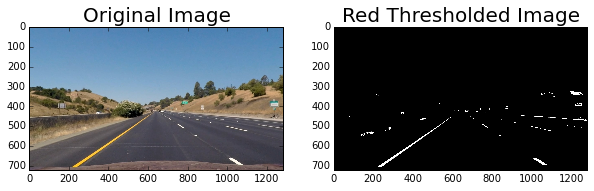

In [25]:
thresh = (200, 255)
binary = np.zeros_like(channel_R)
binary[(channel_R > thresh[0]) & (channel_R <= thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Red Thresholded Image', fontsize=20)
plt.show()
plt.savefig('output_images/R_thresh')

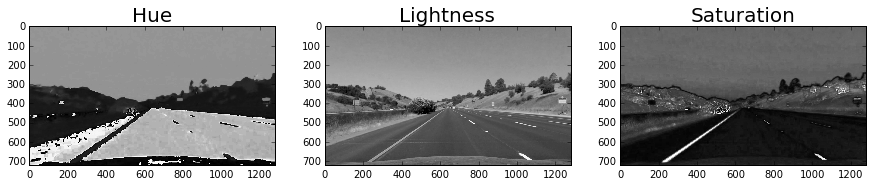

In [26]:
#visualising channels of HLS color space
hls = cv2.cvtColor(sample_img, cv2.COLOR_RGB2HLS)
channel_H = hls[:,:,0]
channel_L = hls[:,:,1]
channel_S = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(channel_H, cmap='gray')
ax1.set_title('Hue', fontsize=20)
ax2.imshow(channel_L, cmap='gray')
ax2.set_title('Lightness', fontsize=20)
ax3.imshow(channel_S, cmap='gray')
ax3.set_title('Saturation', fontsize=20)
plt.show()
plt.savefig('output_images/HLS')

### As seen above, the Hue and the Saturation channels are detecting the lanes the best. Lets apply threshold on both of them

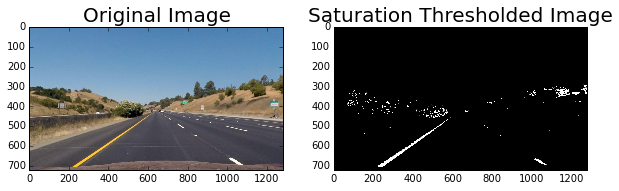

In [27]:
thresh = (120, 255)
binary = np.zeros_like(channel_S)
binary[(channel_S > thresh[0]) & (channel_S <= thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Saturation Thresholded Image', fontsize=20)
plt.show()
plt.savefig('output_images/S_thresh')

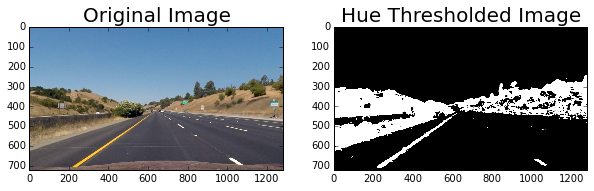

In [28]:
thresh = (15, 80)
binary = np.zeros_like(channel_H)
binary[(channel_H > thresh[0]) & (channel_H <= thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Hue Thresholded Image', fontsize=20)
plt.show()
plt.savefig('output_images/H_thresh')

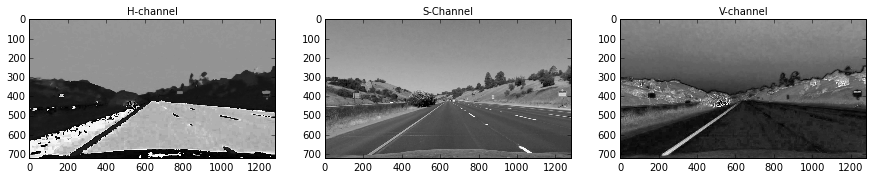

In [29]:
# Visualize HSV color space channels
hsv = cv2.cvtColor(sample_img, cv2.COLOR_RGB2HSV)
channel_H = hsv[:,:,0]
channel_S = hsv[:,:,1]
channel_V = hsv[:,:,2]

fig, axs = plt.subplots(1,3, figsize=(15, 10))
axs = axs.ravel()
axs[0].imshow(channel_H, cmap='gray')
axs[0].set_title('H-channel', fontsize=10)
axs[1].imshow(channel_L, cmap='gray')
axs[1].set_title('S-Channel', fontsize=10)
axs[2].imshow(channel_S, cmap='gray')
axs[2].set_title('V-channel', fontsize=10)
plt.savefig('output_images/HSV')

### The above plots show that all the three channels in HSV can be used for lane detection. The H and S channel can detect white lines as well as yellow lines and V channel can detect the yellow line properly. Lets use the thresholding on the three channels

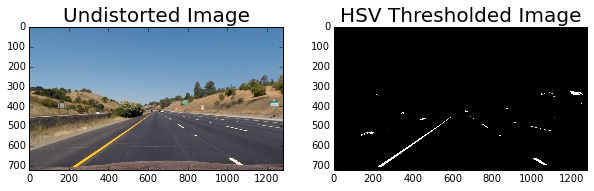

In [30]:
def thresholded_hsv(img, h_thresh=(0,40), s_thresh=(80,255), v_thresh=(200,255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    channel_H = hsv[:,:,0]
    channel_S = hsv[:,:,1]
    channel_V = hsv[:,:,2]
    
    binary = np.zeros_like(channel_H)
    binary[((channel_H>h_thresh[0])&(channel_H<=h_thresh[1]))&((channel_S>s_thresh[0])&(channel_S<=s_thresh[1]))&((channel_V>v_thresh[0])&(channel_V<=v_thresh[1]))] = 1
    return binary

binary_y = thresholded_hsv(img=sample_img, h_thresh=(0,40), s_thresh=(80,255), v_thresh=(200,255))
binary_w = thresholded_hsv(img=sample_img,h_thresh=(0,255), s_thresh=(0,40), v_thresh=(220,255))

final_binary = np.zeros_like(binary_y)

final_binary[(binary_w == 1)|(binary_y == 1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(sample_img)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(final_binary, cmap='gray')
ax2.set_title('HSV Thresholded Image', fontsize=20)
plt.show()
plt.savefig('output_images/hsv_thresh')

### Combining color Thresholds on the S-channel of HLS image

In [31]:
def mag_thresholded(img):
    sobel_kernel = 3
    
    mag_thresh_s = (20,20)
    mag_thresh_l = (20,20)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    
    mag_s = mag_thresh(s, thresh=mag_thresh_s)
    mag_l = mag_thresh(l, thresh=mag_thresh_l)
    
    binary = np.zeros_like(mag_s)
    binary[(mag_s == 1)|(mag_l == 1)] = 1
    
    return binary

def combined_threshold(img):
    binary_yellow = thresholded_hsv(img=img, h_thresh=(0,40), s_thresh=(80,255), v_thresh=(200,255))
    binary_white = thresholded_hsv(img=img,h_thresh=(0,255), s_thresh=(0,40), v_thresh=(220,255))
    
    binary_final = np.zeros_like(binary_yellow)
    
    binary_mag = mag_thresholded(img)
    
    binary_final[(binary_white == 1)|(binary_yellow == 1)|(binary_mag == 1)] = 1
    
    return binary_final

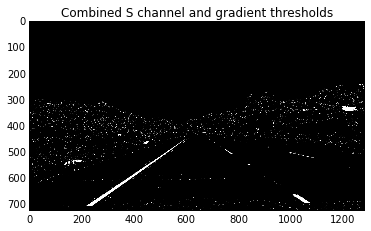

In [32]:
combined_binary = combined_threshold(sample_img)

# Plotting thresholded images
plt.title('Combined S channel and gradient thresholds')
plt.imshow(combined_binary, cmap='gray')
plt.savefig('output_images/combined_final_thresh')

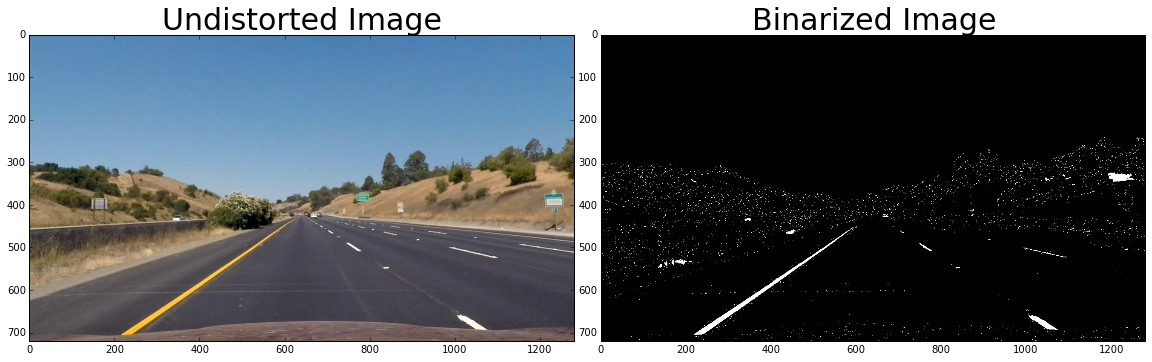

In [33]:
# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(sample_img)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(combined_binary, cmap="gray")
ax2.set_title('Binarized Image', fontsize=30)
plt.savefig('output_images/binarized')

In [34]:
binarize_images = []
for image in test_undistorted_rgb:
    binarize_images.append(combined_threshold(image))

## Perspective Transform

In [35]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def image_warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, Minv


In [36]:
#source and destination points for transform
def src_dst(binary_img):
    src = np.float32([(500,450),
                      (780,450), 
                      (150,690), 
                      (1150,690)])
    dst = np.float32([(450,0),
                      (binary_img.shape[1]-450,0),
                      (450,binary_img.shape[0]),
                      (binary_img.shape[1]-450,binary_img.shape[0])])
    return src, dst

sample_binary_img = binarize_images[0]
src, dst = src_dst(sample_binary_img)

In [56]:
print (src, dst)

(array([[  500.,   450.],
       [  780.,   450.],
       [  150.,   690.],
       [ 1150.,   690.]], dtype=float32), array([[ 450.,    0.],
       [ 830.,    0.],
       [ 450.,  720.],
       [ 830.,  720.]], dtype=float32))


In [37]:
warped_sample, Minv = image_warp(sample_binary_img, src, dst)

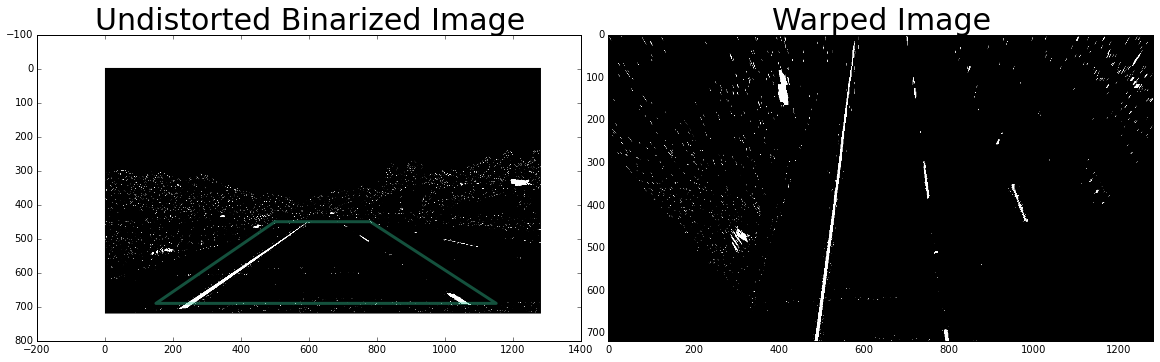

In [38]:
# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(sample_binary_img, cmap='gray')
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_title('Undistorted Binarized Image', fontsize=30)
ax2.imshow(warped_sample, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)
plt.savefig('output_images/warped')

In [39]:
#all images unwarped
warped_images = []
for image in binarize_images:
    warped, M = image_warp(image, src, dst)
    warped_images.append(warped)

### Finding lanes 

In [40]:
def lanes(binary_warped, flag = False):
    if flag == True:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if flag == True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if flag == True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return left_fitx, right_fitx, ploty, left_fit, right_fit, out_img, left_fit, right_fit
    else:
        return left_fitx, right_fitx, ploty, left_fit, right_fit, left_fit, right_fit

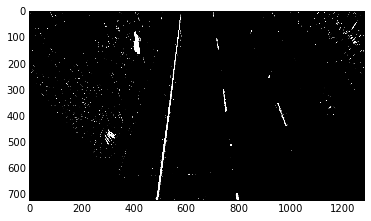

In [41]:
plt.imshow(warped_images[0], cmap="gray")

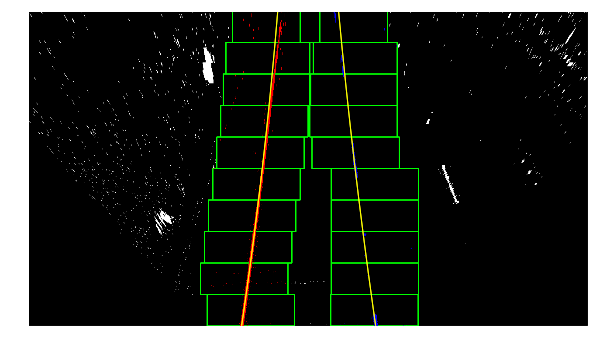

In [42]:
binary_warped = warped_images[0]

left_fitx, right_fitx, ploty, left_fit, right_fit, out_img, left_fit, right_fit = lanes(binary_warped, flag=True)

plt.figure(figsize=(10,6))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off");
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/lanes_detected')

### Radius of curvature

In [43]:
def radius_of_curvature(ploty, left_fit, right_fit, binary_warped):
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/700.0 # meters per pixel in x dimension

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    left_pos = (left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2])
    right_pos = (right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2])

    lanes_mid = (left_pos+right_pos)/2.0

    distance_from_mid = binary_warped.shape[1]/2.0 - lanes_mid

    deviation = xm_per_pix*distance_from_mid

    return left_curverad, right_curverad, deviation

In [44]:
left, right, deviation = radius_of_curvature(ploty, left_fit, right_fit, binary_warped)
print (left, right, deviation)

(11028.193506481619, 14395.710458151772, -0.0061203067526906648)


### Now we know where the lines are. In the next frame of video we don't need to do a blind search again, but instead we can just search in a margin around the previous line position

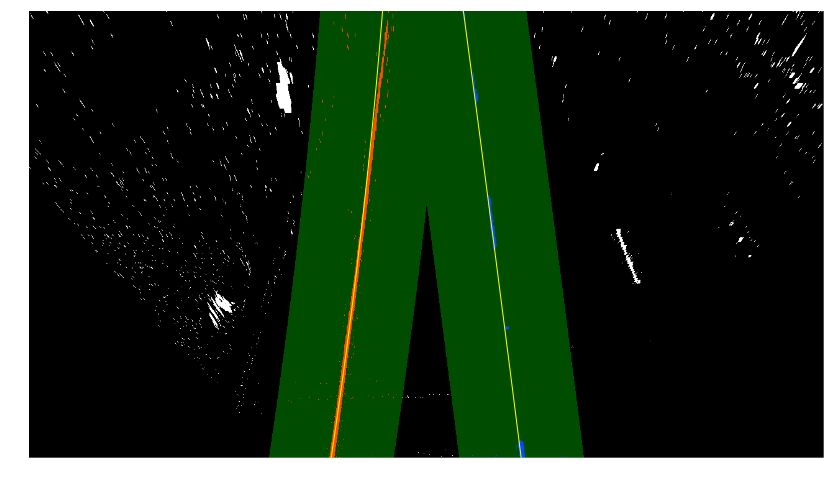

In [46]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.figure(figsize=(16,8))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off");
plt.savefig('output_images/margin')

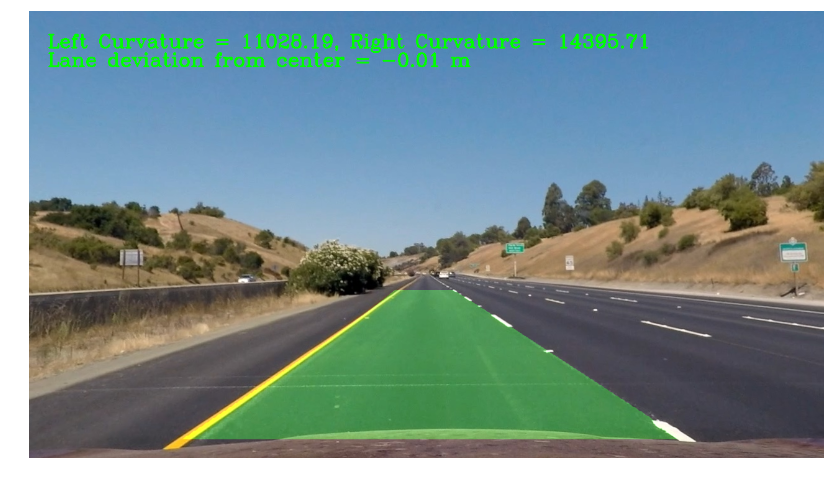

In [48]:
def lanes_on_image(binary_warped, undistorted, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius, lane_deviation):
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    curvature_text = "Left Curvature = " + str(np.round(left_radius, 2)) + ", Right Curvature = " + str(np.round(right_radius, 2)) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, deviation_text, (30, 90), font, 1, (0,255,0), 2)
        
    return result

result = lanes_on_image(binary_warped, test_undistorted_rgb[0], Minv, left_fitx, right_fitx, ploty, left, right, deviation)
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis("off");
plt.savefig('output_images/lane_on_image')

In [52]:
def process_image(image):
    """
    Execute our image processing pipeline on the provided image.
    """
    undistorted = cal_undistort(image, objPoints, imgPoints)
    combined_binary = combined_threshold(undistorted)
    src, dst = src_dst(image)
    binary_warped, Minv = image_warp(combined_binary, src, dst)
    left_fitx, right_fitx, ploty, left_fit, right_fit, left_fit, right_fit = lanes(binary_warped)
    left, right, deviation = radius_of_curvature(ploty, left_fit, right_fit, binary_warped)
    lane_lines_img = lanes_on_image(binary_warped, undistorted, Minv, left_fitx, right_fitx, ploty, left, right, deviation)
    return lane_lines_img


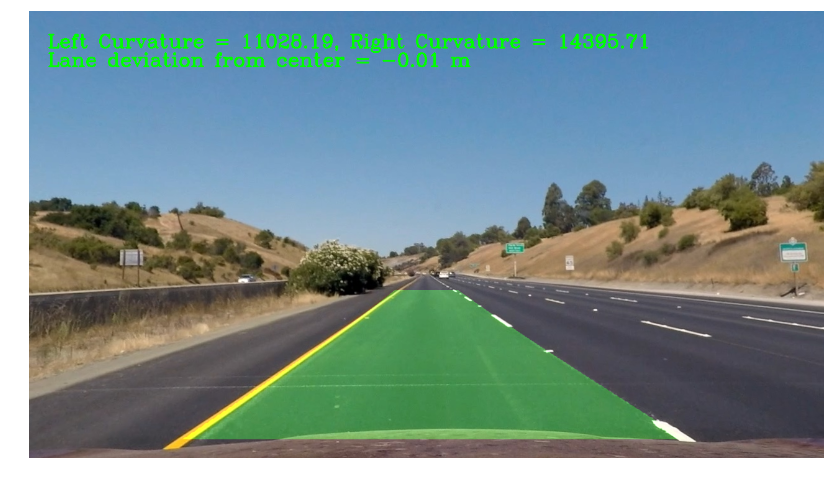

In [54]:
# Run on a test image
img = cv2.imread("test_images/straight_lines1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = process_image(img)

plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis("off");
plt.savefig('output_images/test_pipeline')

In [55]:
video_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [14:46<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 15min 2s, sys: 37.6 s, total: 15min 40s
Wall time: 14min 47s
